In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf
from tensorflow import keras
tf.__version__, keras.__version__

('2.10.0', '2.10.0')

In [3]:
# Importing the dataset:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist

In [4]:
# Creating some validation sets:
from sklearn.model_selection import train_test_split
x_train, x_valid = train_test_split(x_train, test_size = 0.2)

In [5]:
# Normalizing the data:
x_train, x_test, x_valid = tf.cast(x_train, tf.float32)/255., tf.cast(x_test, tf.float32)/255., tf.cast(x_valid, tf.float32)/255.

In [6]:
# Creating a model for generation:
class Generator(keras.models.Model):
    """
    This is a custom generator responsible for generating MNIST images with subtle accuracy. 
    Please pair it will a proper 28 x 28 discriminator.
    """
    def __init__(self, act = 'selu', **kwargs):
        super(Generator, self).__init__(**kwargs)
        self.activation = keras.activations.get(act)
        self.noise = keras.layers.Dense(100, activation = self.activation, input_shape = [100])
        self.hidden1 = keras.layers.Dense(150, activation = self.activation)
        self.hidden2 = keras.layers.Dense(150, activation = self.activation)
        self.out = keras.layers.Dense(784, activation = 'sigmoid')
        self.reshape = keras.layers.Reshape([28, 28, 1])
    def call(self, inputs):
        x = self.noise(inputs)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return self.reshape(x)

In [7]:
# Creating a discriminator:
class Discriminator(keras.models.Model):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(32, kernel_size = 5, strides = 2, padding = "same", activation = tf.keras.layers.LeakyReLU(0.2), input_shape = [28, 28])
        self.conv2 = keras.layers.Conv2D(64, kernel_size = 5, strides = 2, padding = "same", activation = tf.keras.layers.LeakyReLU(0.2))
        self.dropout = keras.layers.Dropout(0.4)
        self.flatten = keras.layers.Flatten()
        self.out = keras.layers.Dense(1, activation = 'sigmoid')
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.out(x)
        return x

In [8]:
# Creating the entire model:
model = keras.models.Sequential([Generator(), Discriminator()])

In [9]:
# Creating a dataset:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size = batch_size, drop_remainder = True).prefetch(1)

In [10]:
# Creating general training:
def train(model, x, y, loss_fn = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.optimizers.Nadam()):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_fn(y, predictions)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

In [11]:
# Creating training steps for discriminator:
@tf.function
def train_d(model, x_batch, noise):
    generator, discriminator = model.layers
    generated_images = generator(noise)
    input = tf.concat([generated_images, x_batch[..., tf.newaxis]], axis = 0)
    y = tf.constant([[0.]] * 32 + [[1.]] * 32) # Creating the outputs to teach the model.
    discriminator.trainable = True
    train(discriminator, input, y)

In [12]:
# Creating training step for generator:
@tf.function
def train_g(model, noise, batch_size):
    generator, discriminator = model.layers
    discriminator.trainable = False
    y = tf.constant([[1.]] * batch_size)
    train(model, noise, y)

In [13]:
# Creating a training loop:
@tf.function
def train_gan(model, dataset, batch_size = 32, codings_size = 100, n_epochs = 20):
    for epoch in tf.range(n_epochs):
        for x_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape = [batch_size, codings_size])
            train_d(model, x_batch, noise)

            # phase 2 - training the generator:
            noise = tf.random.normal(shape = [batch_size, codings_size])
            train_g(model, noise, batch_size)

In [14]:
# training the function:
train_gan(model, dataset, batch_size)

In [15]:
model.trainable = False

In [16]:
noise = tf.random.normal(shape = [batch_size, 100])
encoder = model.layers[0]
predictions = encoder.predict(noise)

1/1 [==============================] - 0s 67ms/step


In [17]:
from matplotlib import pyplot as plt

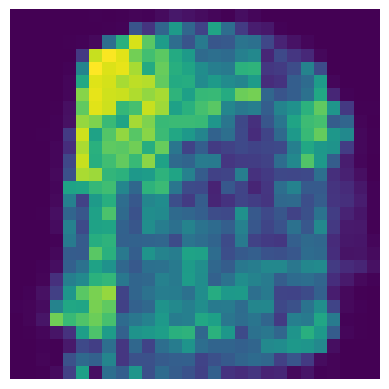

In [18]:
plt.imshow(predictions[0])
plt.axis(False)
plt.show()

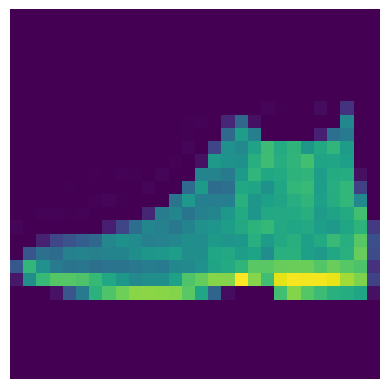

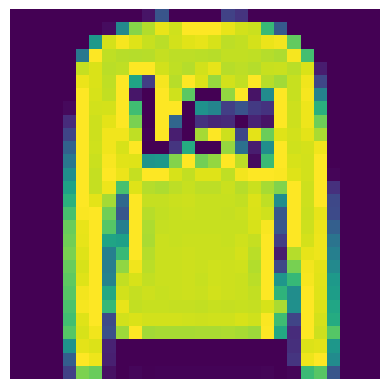

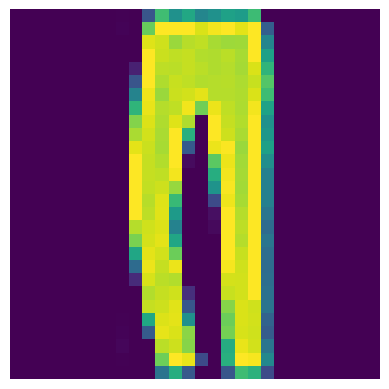

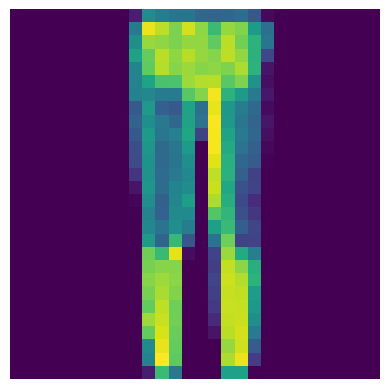

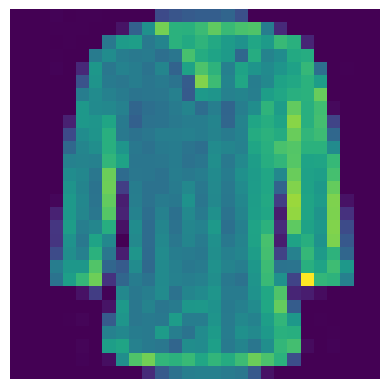

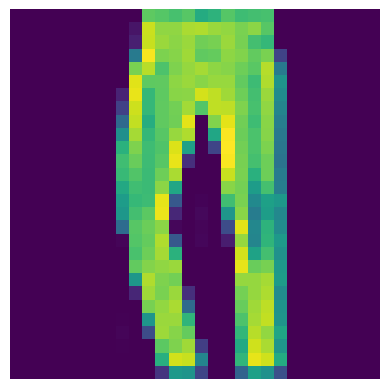

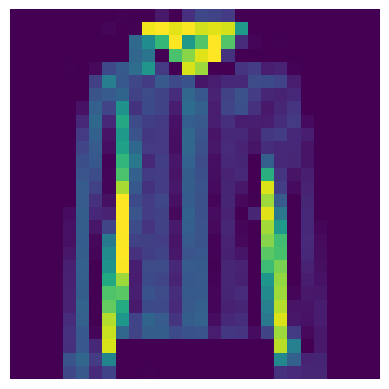

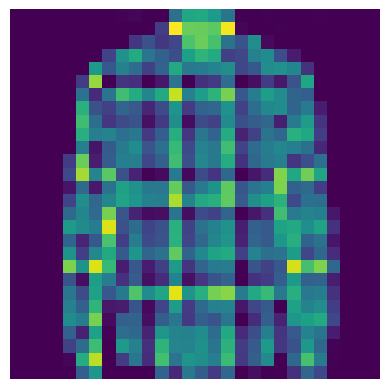

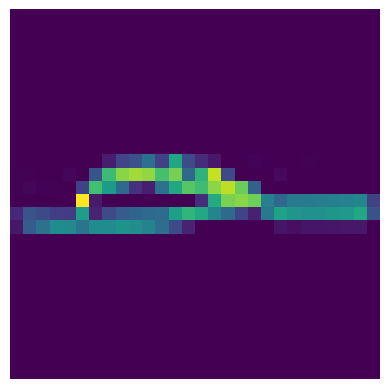

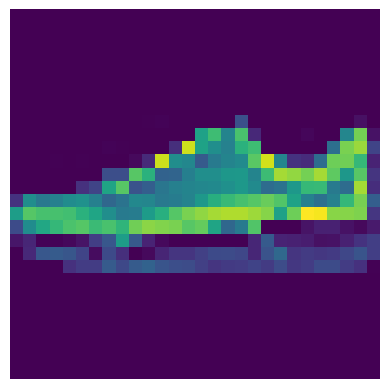

In [20]:
for i in range(10):
    plt.imshow(x_test[i])
    plt.axis(False)
    plt.show()